In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
%matplotlib notebook

<ipython-input-1-ecb51f2daeeb>:2: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import matplotlib.pyplot as plt


In [2]:
# tools
def set_prop_cycle(self, clist):
    """
    Set the color cycle for any future plot commands on this Axes.

    *clist* is a list of mpl color specifiers.
    """
    self._get_lines.set_color_cycle(clist)
    self._get_patches_for_fill.set_color_cycle(clist)

In [19]:
# Network
REFRAC_TIME = 10
VTHRES = 10
def membrane(syn_input, old_membrane, refractory_time,
REFRAC_TIME = REFRAC_TIME, vthres=VTHRES, v_reset = 0.0, dt=1, tau_mem=10):
    if refractory_time > 0:
        refractory_time -= 1
        spiking = False
        return v_reset, refractory_time, spiking
    elif (old_membrane + syn_input) > vthres:
        spiking = True
        refractory_time = REFRAC_TIME
        return v_reset, refractory_time, spiking
    else:
        spiking = False
        return (old_membrane + syn_input)*np.exp(-dt/tau_mem), refractory_time, spiking

SPIKE_RES = 10000
def spike(time, tau_syn=5, res = SPIKE_RES, single_exp=False):
    trace = np.zeros(res)
    if time is not None:
        time = int(time)
        trace[time] = 1
        if single_exp:
            spike_kernel = single_exp_kernel(tau_syn)
        else:
            spike_kernel = kernel(tau_syn)
        trace = np.convolve(spike_kernel, trace)[:res]
    return trace

def spike_(time, tau_syn=5, res = SPIKE_RES):
    trace = np.zeros(res)
    if time is not None:
        time = int(time)
        trace[time] = 1
        spike_kernel = kernel(tau_syn)
        trace = np.convolve(spike_kernel, trace)[:res]
    return trace

def nospike(res=SPIKE_RES):
    return np.zeros(res)


def membrane_trace(syn_input_tr, vthres=VTHRES):
    n = len(syn_input_tr)
    mem_tr = np.zeros(n)
    spiking_tr = np.zeros(n)
    remaining_refrac_time = 0
    
    for i in range(n):
        mem_tr[i], remaining_refrac_time, spiking_tr[i] = membrane(syn_input_tr[i], mem_tr[i - 1], 
                                                          remaining_refrac_time, vthres=vthres)
    return mem_tr, spiking_tr

# INPUT:
# a pattern (2d image) is mapped to a spiketrain (pattern2spiketrain)
# a spiketrain turned into a trace (spiketrain2trace)
# the trace is then folded with the weight matrix resulting in the synaptic input of the next layer (tracexweight)
# the 

# HIDDEN:
# 



def pattern2spiketrain(pattern, early=10, late=90, jitter=5):
    # returns a (n x 2) array with n spikes containing spike time and firing unit
    # array([(time, unit),
    #         ...])
    n = len(pattern)
    spiketrain = np.zeros((n, 2))
    noise = np.random.randint(-jitter,jitter,size=n)
    for i, p in enumerate(pattern):
        spiketrain[i, 0] = (early if p == 1 else late) + noise[i]
        spiketrain[i, 1] = i
    return spiketrain


def spiketrain2trace(spiketrain, n_units):
    # spiketrain: (nx2), n #spikes
    # return trace: (#units, time)
    trace = np.zeros((n_units, SPIKE_RES))
    for time, unit in spiketrain:
        if time is not None:
            trace[int(unit)] += spike(int(time))
        else:
            pass
    return trace

def tracexweight(trace, weights):
    # weights: (m, n) where m is #inputs and n #outputs
    # trace: (m, t) where m is #inputs and t the time dim
    # return: (n,t)
    return (weights.T[:,:,None]*trace[None, :,:]).sum(axis=1)


def spikingtr2spiketrain(spiking_tr):
    # spiking_tr: (#units, time), boolean array with "true" where a unit fired
    # return: a (#spikes x 2) array with #spikes where each spike contains spike time and firing unit
    spiketrain = None
    for unit, spiking in enumerate(spiking_tr):
        spiketimes = (spiking*range(SPIKE_RES))[spiking.astype(bool)]
        if len(spiketimes) != 0:
            if spiketrain is not None:
                spiketrain = np.vstack((spiketrain, np.array(list(zip(spiketimes, len(spiketimes)*[unit])))))
            else:
                spiketrain = np.array(list(zip(spiketimes, len(spiketimes)*[unit])))
    if spiketrain is None:
        return np.array([[None,None]])
    else:
        return spiketrain
    
def kernel(tau, res=200, normed=True):
    x = np.arange(res)
    ker = x*np.exp(-x/tau)
    if normed:
        ker /= sum(ker)
    return ker

def single_exp_kernel(tau, res=200, normed=True):
    x = np.arange(res)
    ker = np.exp(-x/tau)
    if normed:
        ker /= sum(ker)
    return ker


<IPython.core.display.Javascript object>


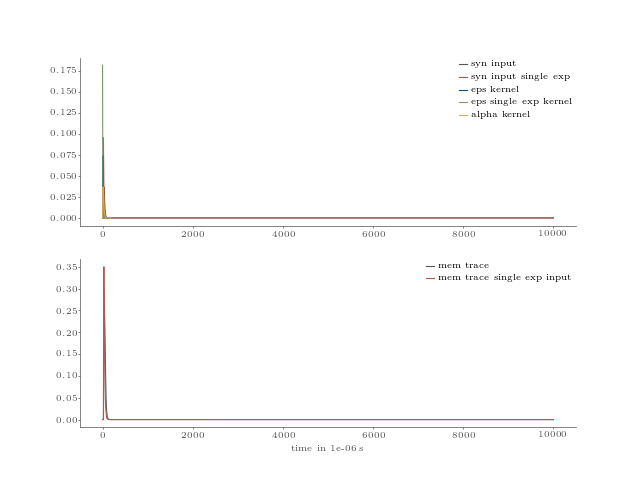

Text(0.5, 0, 'time in 1e-06 s')

In [20]:
tau_mem = 10e-6
tau_syn = 10e-6
tau_eps = 5e-6
tau_alpha = 10e-6
late = 90e-6
early = 10e-6
window_early = (20e-6, 50e-6)
window_late = (90e-6, 120e-6)

samplingperiode = 1e-6
# update parameters
tau_mem /= samplingperiode
tau_syn /= samplingperiode
tau_eps /= samplingperiode
tau_alpha /= samplingperiode

eps = kernel(tau_eps)
eps_single = single_exp_kernel(tau_eps)
alpha = kernel(tau_alpha)
syn_input = spike(20e-6/samplingperiode, tau_syn=tau_syn)
syn_input_single =  spike(20e-6/samplingperiode, tau_syn=tau_syn, single_exp=True)
mem_tr, _ = membrane_trace(syn_input)
mem_tr_single, _ = membrane_trace(syn_input_single)
fig, axes = plt.subplots(2)
axes[0].plot(syn_input, label="syn input")
axes[0].plot(syn_input_single, label="syn input single exp")
axes[0].plot(eps, label="eps kernel")
axes[0].plot(eps_single, label="eps single exp kernel")
axes[0].plot(alpha, label="alpha kernel")
axes[0].legend()
axes[1].plot(mem_tr, label="mem trace")
axes[1].plot(mem_tr_single, label="mem trace single exp input")
axes[1].legend()
axes[1].set_xlabel("time in %s s" % samplingperiode)

input freq: 0.0 kHz


<IPython.core.display.Javascript object>


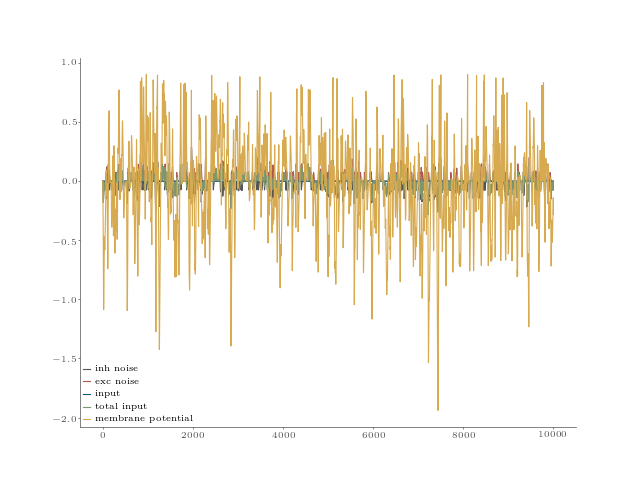

In [25]:
freq_input_squence = np.arange(-100e3, 100e3, 10e3)
freq_input = freq_input_squence[10]
print("input freq:", freq_input*1e-3 , "kHz")
vthres = 1
period = SPIKE_RES*1e-6 #µs
freq_noise = 40e3 #Hz
# synaptic noise input
n_noise_spikes = np.int(freq_noise*period)
noise_spiketimes = np.random.randint(0,SPIKE_RES, size=2*n_noise_spikes)
noise_spiketrain = np.array(list(zip(noise_spiketimes, [0,]*n_noise_spikes + [1,]*n_noise_spikes)))
synaptic_input_exc_inh = spiketrain2trace(noise_spiketrain, 2)
synaptic_noise_input = synaptic_input_exc_inh[1] - synaptic_input_exc_inh[0]

# synaptic input
sign = np.sign(freq_input)
freq_input *= sign
n_spikes = np.int(freq_input*period)
spiketimes = np.random.randint(0,200, size=n_spikes)
spiketrain = np.array(list(zip(spiketimes, [0,]*n_spikes)))
synaptic_input = spiketrain2trace(spiketrain, 1)

total_synaptic_input = synaptic_noise_input + sign*synaptic_input[0]

# membrane trace
mem_tr, spiking_tr = membrane_trace(total_synaptic_input,vthres)

plt.figure()
plt.plot(-synaptic_input_exc_inh[0], label="inh noise")
plt.plot(synaptic_input_exc_inh[1], label="exc noise")
plt.plot(synaptic_input[0], label="input")
plt.plot(synaptic_noise_input, label="total input")
plt.plot(mem_tr, label="membrane potential")
plt.legend()



<IPython.core.display.Javascript object>


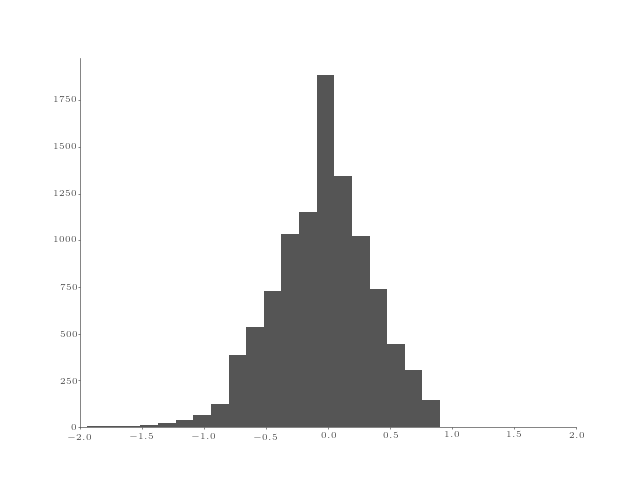

(-2, 2)

In [26]:
plt.figure()
plt.hist(mem_tr, bins=20)
plt.xlim(-2,2)